# Modelo de clasificación multiclase para tipos de pases (passholder_type)

In [164]:
# Librerias
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score

#### Definición de los tipos de datos

In [165]:
dtypes = {
    "trip_id": "string", 
    "duration": "int8", 
    "start_time": "string", # Posteriormente parsear a datetime.
    "end_time":"string", #  Posteriormente parsear a datetime.
    "start_lat":"float32", 
    "start_lon":"float32", 
    "end_lat":"float32", 
    "end_lon":"float32", 
    "bike_id":"string", 
    "plan_duration":"float32", # Por los nulos
    "trip_route_category":"string", 
    "passholder_type":"string", 
    "start_station":"string", 
    "end_station":"string", 
}

#### Carga de los datos con los tipos de datos definidos.


In [166]:
df = pd.read_csv('Data/train_set_eda.csv', dtype=dtypes)

#### Gestión de valores faltantes

En el EDA, algunos valores faltantes no fueron modificados / eliminados. para el modelo es necesario tomar decisiones sobre cómo manejarlos.

In [167]:
df.isna().sum()

trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               5531
start_lon               5531
end_lat                18489
end_lon                18489
bike_id                    0
plan_duration            208
trip_route_category        0
passholder_type            0
start_station              0
end_station                0
dtype: int64

## Formateo de datos

In [168]:
# Fecha
df['start_time'] = pd.to_datetime(df['start_time'], format='mixed')
df['end_time'] = pd.to_datetime(df['end_time'], format='mixed')

#### Gestión valores invalidos en "duration"

En el EDA nos percatamos de valores negativos en dicha variable, verificar validez de datos, entendiendo que la duración no puede ser un número negativo.

In [169]:
df[df['duration']<0]

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
3,129547190,-118,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
40,110113350,-96,2018-11-23 09:37:00,2018-11-24 16:44:00,34.014309,-118.491341,NaN,NaN,12227,1.0,One Way,Walk-up,4215,3000
107,87701064,-106,2018-05-19 13:49:00,2018-05-19 16:19:00,33.984341,-118.471550,33.995560,-118.481552,12157,1.0,One Way,One Day Pass,4210,4214
134,64809950,-116,2017-12-26 20:41:00,2017-12-27 11:49:00,34.043732,-118.260132,34.039982,-118.266403,06645,0.0,One Way,Walk-up,3018,3047
194,144520567,-39,2020-07-05 19:44:00,2020-07-06 07:53:00,34.090279,-118.277191,34.110031,-118.287163,6321,1.0,One Way,Walk-up,4493,4474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697225,127807106,-96,2019-08-22 14:49:00,2019-08-23 18:58:00,34.092491,-118.291443,34.098011,-118.287071,19829,365.0,One Way,Walk-up,4302,4303
697237,176446568,-57,2021-11-16 16:32:00,2021-11-16 19:51:00,34.026291,-118.277687,34.026291,-118.277687,16178,1.0,Round Trip,Walk-up,4266,4266
697309,103548011,-106,2018-08-18 14:29:00,2018-08-18 16:59:00,34.051102,-118.264557,34.043732,-118.260139,06087,30.0,One Way,Monthly Pass,3052,3018
697325,119969579,-79,2019-04-21 13:11:00,2019-04-21 16:08:00,33.741360,-118.278069,33.733521,-118.277786,05810,1.0,One Way,Walk-up,4134,4133


- Se valida que los datos con numeros negativos de duración de viaje tienen fechas de inicio y fin coherentes. 
- Valor negativo en duration es incorrecto, se calculará uno nuevo y se imputarán dichos valores.

In [170]:
df['duration_imputada'] = df['end_time'] - df['start_time']

- Eliminamos valores que duracion imputada sea <= 0

In [171]:
df = df[df['duration_imputada']>timedelta(minutes=0)].copy()

In [172]:
# Imputar el nuevo valor de duración calculado
df['duration']= df['duration_imputada'].dt.seconds / 60

#### Eliminación de la variable plan_duration del modelo

La variable plan_duration presenta ruido, inconsistencias y valores nulos, por lo cual no será utilizada para entrenar el modelo.

#### Generación de variables adicionales para el modelo

Se crean nuevas variables que pueden aportar al modelo

In [173]:
df['start_hour'] = df['start_time'].dt.hour
df['start_day'] = df['start_time'].dt.day
df['start_month'] = df['start_time'].dt.month
df['start_year'] = df['start_time'].dt.year
df['start_weekday'] = df['start_time'].dt.weekday  
df['is_weekend'] = df['start_weekday'].apply(lambda x: 1 if x >= 5 else 0)


### Análisis de clases

Una vez agregadas las nuevas variables, analizamos la distribución de las clases.

In [174]:
df['passholder_type'].value_counts(normalize=True) * 100

passholder_type
Monthly Pass    56.611629
Walk-up         30.462555
One Day Pass     6.373632
Annual Pass         4.888
Flex Pass        1.664183
Name: proportion, dtype: Float64

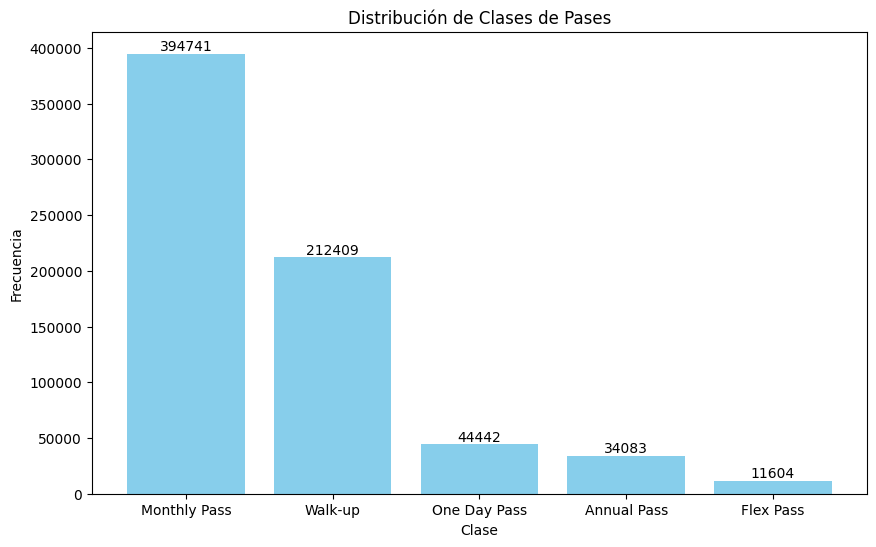

In [175]:
# Contar las frecuencias de cada tipo de pase
passholder_counts = df['passholder_type'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(passholder_counts.index, passholder_counts.values, color='skyblue')

# Añadir los valores sobre las barras
for i, value in enumerate(passholder_counts.values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

# Etiquetas y título
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.title('Distribución de Clases de Pases')

# Mostrar el gráfico
plt.show()

#### Distribución de clases

Las clases de nuestra variable objetivo se encuentran desvalanceadas, es importante tener eso en cuenta para evitar sesgar el modelo.

#### Variables seleccionadas para el modelo

Estas variables fueron seleccionadas porque contienen información relevante sobre los viajes. Se descartaron variables como el ID del viaje y el ID de las bicicletas que no aportan información útil al modelo, para con la variable objetivo.

In [176]:
['start_hour', 'start_weekday','start_day','start_month','start_year','is_weekend' , 'start_station',
 'end_station', 'trip_route_category', 'duration']

['start_hour',
 'start_weekday',
 'start_day',
 'start_month',
 'start_year',
 'is_weekend',
 'start_station',
 'end_station',
 'trip_route_category',
 'duration']

#### Manejo de variables categóricas

Las variables categóricas deben ser transformadas a valores numéricos para el correcto funcionamiento del modelo

In [177]:
# Aplicar Label Encoding a variables categóricas
cat_columns = ['start_station', 'end_station', 'trip_route_category']
for col in cat_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

#### Codificación de variables categóricas y de la variable objetivo

Además de utilizar Label Encoding para las variables categóricas, también se aplicará esta técnica a la variable objetivo, ya que está en formato categórico.

In [178]:
# Inicializar el codificador
le = LabelEncoder()

# Transformar la columna 'passholder_type' a números
df['passholder_type_encoded'] = le.fit_transform(df['passholder_type'])

# Ver el mapeo de clases
class_mapping = {cls: int(value) for cls, value in zip(le.classes_, le.transform(le.classes_))}
print("Mapeo de clases:", class_mapping)

# Usar la nueva variable como objetivo
y = df['passholder_type_encoded']

Mapeo de clases: {'Annual Pass': 0, 'Flex Pass': 1, 'Monthly Pass': 2, 'One Day Pass': 3, 'Walk-up': 4}


#### División de los datos en entrenamiento y prueba

En este paso, se dividirán los datos en conjuntos de entrenamiento y prueba para evaluar el modelo y realizar pruebas sobre su desempeño.

In [179]:
# Separar features y variable objetivo antes del split
features = ['start_hour', 'start_weekday','start_day','start_month','start_year','is_weekend' , 'start_station',
            'end_station', 'trip_route_category', 'duration']

X = df[features]
y = df['passholder_type_encoded']  # Variable objetivo

# Division de los datos utilizando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelo: LightGBM
LightGBM es un algoritmo rápido y eficiente para problemas de clasificación y regresión.

Precisión y velocidad: Optimizado para grandes volúmenes de datos.

Flexibilidad: Captura relaciones complejas y maneja datos no lineales.

Eficiencia: Consume menos memoria y es más rápido que otros modelos.

Manejo de desbalanceo: Permite asignar pesos a clases minoritarias.

Interpretabilidad: Proporciona importancia de características.

In [180]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Definir el modelo LightGBM
lgbm = LGBMClassifier(
    n_estimators=100,  # Número de árboles (boosting rounds)
    learning_rate=0.1,  # Tasa de aprendizaje
    max_depth=-1,       # Profundidad máxima (sin límite)
    random_state=42,    # Semilla para reproducibilidad
    n_jobs=-1           # Usar todos los núcleos del CPU
)

# Entrenar el modelo
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 557823, number of used features: 10
[LightGBM] [Info] Start training from score -3.020090
[LightGBM] [Info] Start training from score -4.094242
[LightGBM] [Info] Start training from score -0.569804
[LightGBM] [Info] Start training from score -2.752708
[LightGBM] [Info] Start training from score -1.186973


LGBMClassifier(n_jobs=-1, random_state=42)

### Predicciones y evaluación del modelo

In [181]:
# Predecir en el conjunto de prueba
y_pred = lgbm.predict(X_test)

# Calcular precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")
# Evaluar el modelo
print(classification_report(y_test, y_pred, target_names=le.classes_))

Precisión del modelo: 0.7088
              precision    recall  f1-score   support

 Annual Pass       0.79      0.09      0.16      6863
   Flex Pass       0.62      0.03      0.05      2306
Monthly Pass       0.72      0.91      0.81     79216
One Day Pass       0.51      0.09      0.15      8878
     Walk-up       0.68      0.59      0.63     42193

    accuracy                           0.71    139456
   macro avg       0.66      0.34      0.36    139456
weighted avg       0.70      0.71      0.67    139456



#### Análisis de la importancia de las características (Feature Importance)

In [182]:
# Obtener la importancia de las características
feat_importances = pd.DataFrame({
    'Feature': X_train.columns,  # Nombres de las características
    'Importance': lgbm.feature_importances_  # Importancia de cada característica
})

# Ordenar las características por importancia (de mayor a menor)
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Mostrar el DataFrame con las importancias
print(feat_importances)

               Feature  Importance
6        start_station        3505
7          end_station        3120
9             duration        1927
4           start_year        1830
0           start_hour        1704
3          start_month        1391
2            start_day         615
1        start_weekday         541
8  trip_route_category         367
5           is_weekend           0




Eliminamos variable sin importancia y comprobamos que precesión sigue igual


In [183]:
# Seleccionar características relevantes
features = ['start_station','end_station','start_hour','start_year', 'start_month', 'start_day','start_weekday', 'trip_route_category', 'duration']

X = df[features]
y = df['passholder_type_encoded']  # Variable objetivo

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
# Definir el modelo LightGBM
lgbm = LGBMClassifier(
    n_estimators=100,  # Número de árboles (boosting rounds)
    learning_rate=0.1,  # Tasa de aprendizaje
    max_depth=-1,       # Profundidad máxima (sin límite)
    random_state=42,    # Semilla para reproducibilidad
    n_jobs=-1           # Usar todos los núcleos del CPU
)

# Entrenar el modelo
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 557823, number of used features: 9
[LightGBM] [Info] Start training from score -3.020090
[LightGBM] [Info] Start training from score -4.094242
[LightGBM] [Info] Start training from score -0.569804
[LightGBM] [Info] Start training from score -2.752708
[LightGBM] [Info] Start training from score -1.186973


LGBMClassifier(n_jobs=-1, random_state=42)

In [185]:
# Predecir en el conjunto de prueba
y_pred = lgbm.predict(X_test)

# Calcular precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")
# Evaluar el modelo
print(classification_report(y_test, y_pred, target_names=le.classes_))

Precisión del modelo: 0.7088
              precision    recall  f1-score   support

 Annual Pass       0.79      0.09      0.16      6863
   Flex Pass       0.62      0.03      0.05      2306
Monthly Pass       0.72      0.91      0.81     79216
One Day Pass       0.51      0.09      0.15      8878
     Walk-up       0.68      0.59      0.63     42193

    accuracy                           0.71    139456
   macro avg       0.66      0.34      0.36    139456
weighted avg       0.70      0.71      0.67    139456



#### Cross Validation

La validación cruzada (Cross Validation) es una técnica clave para evaluar modelos de manera más robusta y confiable. Su importancia radica en:

Mejorar la generalización: Minimiza el riesgo de sobreajuste (overfitting) al probar el modelo en varios subconjuntos de datos.

Proporcionar métricas más precisas: En lugar de basarse en una sola división de datos (entrenamiento-prueba), utiliza múltiples particiones para obtener una estimación más realista del rendimiento del modelo.

Optimizar el uso de los datos: Aprovecha al máximo el conjunto de datos, ya que cada observación se usa tanto para entrenar como para evaluar en diferentes iteraciones.

In [186]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Configurar StratifiedKFold para cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Realizar cross-validation
scores = cross_val_score(lgbm, X_train, y_train, cv=skf, scoring='accuracy')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 446258, number of used features: 9
[LightGBM] [Info] Start training from score -3.020089
[LightGBM] [Info] Start training from score -4.094295
[LightGBM] [Info] Start training from score -0.569803
[LightGBM] [Info] Start training from score -2.752714
[LightGBM] [Info] Start training from score -1.186971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 446258, number of used features: 9
[LightGBM] [Info] Start training from score -3.020089
[LightGBM] [Info] Start training fro

In [187]:
# Imprimir los resultados
print(f"Mean accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Mean accuracy: 0.7081 ± 0.0018


#### Conclusión validación cruzada

- CrossValidation =  0.7081 ± 0.0018
- Modelo original = 0.7088

Se confirma el buen desempeño del modelo, generalizando bien en distintos conjuntos de datos.

In [188]:
# Exportar el modelo
import joblib
joblib.dump(lgbm, 'Modelo/lightgbm_model.pkl')

['Modelo/lightgbm_model.pkl']

#### Conclusión final 

- El modelo logra una precisión de 68%. Dicho valor puede ser un buen punto de partida para mejorar el modelo mediante ajuste de hiperparámetros, selección de características o ingeniería de características.

- Las variables con mayor impacto sobre el modelo fueron las estaciones de inicio y fin. indicando que la variable objetivo (tipo de pase) esta muy determinada por la ubicación. Con menor relevancia las variables temporales, relacionadas con la hora del dia, año y mes, indican que el tipo de pase esta influenciado por variaciones temporales, lo cual ya previamos desde el EDA.

- Para mejorar la presición del modelo se podria evaluar la transformación y/o inclusión de nuevas variables o información contextual adicional, como datos sobre vacaciones, festividades, distancias recorridas, datos climatológicos.